In [379]:
from VIPurPCAvsMC import *
import jax.numpy as np
import jax
from jax import jacrev, vmap

from sklearn.decomposition import PCA
from utils import *
import seaborn as sns
import time

import matplotlib.pyplot as plt
from matplotlib import rcParams

cm = 1 / 2.54
plt.rc('font', size=8)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
plt.rc('axes', labelsize=8)
rcParams['font.family'] = "sans-serif"
rcParams['font.sans-serif'] = "Helvetica"

In [14]:
def confidence_ellipse(mean_x, mean_y, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [325]:
n=50
p=2
X, y = make_blobs(n_samples=n, n_features=p, centers=[[-2, 0],[2, 0]], random_state=27, shuffle=False, cluster_std=1)
#X = X*[3, 1, 1, 5, 1]
#n=6
#p=2
#X = np.array([[-10, 0.001], [-7, 0.001], [2, -0.001], [3, 0.01], [4, 0.1], [10, -0.001]])
X = X - np.mean(X, axis=0)
X_flat, X_unflattener = flatten_util.ravel_pytree(X)
p_keep = 2

In [399]:
y

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [326]:
#pca_sklearn = PCA(n_components=p_keep)
#T = pca_sklearn.fit_transform(X)
#T=T*-1
#print(T.shape)

In [419]:
import jax.numpy as np
B = np.identity(p)
for i in range(0, p):
    B = B.at[i, i].set(0.000001)
#B = B.at[0, 1].set(0.05)
#B = B.at[1, 0].set(0.05)
B = B.at[1, 1].set(1)
#B = B.at[0, 0].set(0.1)
B = B.at[0, 1].set(-0.5)
B = B.at[0, 0].set(0.5)
B = B.at[1, 0].set(-0.5)
#A = np.identity(n)
#B = make_spd_matrix(p)
A = np.array(make_spd_matrix(n))
A = np.abs(A)
A = A.at[A < 1].set(1)
A = A.at[0:25, 25:50].set(-A[0:25, 25:50])
A = A.at[25:50, 0:25].set(-A[25:50, 0:25])
#A = -A
for i in range(0, n):
    A = A.at[i, i].set(5)
#test = scipy.stats.matrix_normal.rvs(mean=X, rowcov=A, colcov=B, size=1, random_state=27)
X_flat, X_unflattener = flatten_util.ravel_pytree(X)
#p=p_keep

In [420]:
n=20
p=100
X, y = make_blobs(n_samples=n, n_features=p, centers=4, random_state=2, shuffle=False, cluster_std=5)
B = 1*make_spd_matrix(p, random_state=27)
A = 1*make_spd_matrix(n, random_state=26)
X = scipy.stats.matrix_normal.rvs(mean=X, rowcov=A, colcov=B, size=1, random_state=27) 
scale_values = np.diag(np.array([i for i in range(1, p+1)]))
#X = X.dot(scale_values)
# center X
X = X - np.mean(X, axis=0)
X_flat, X_unflattener = flatten_util.ravel_pytree(X)
p_keep = 2

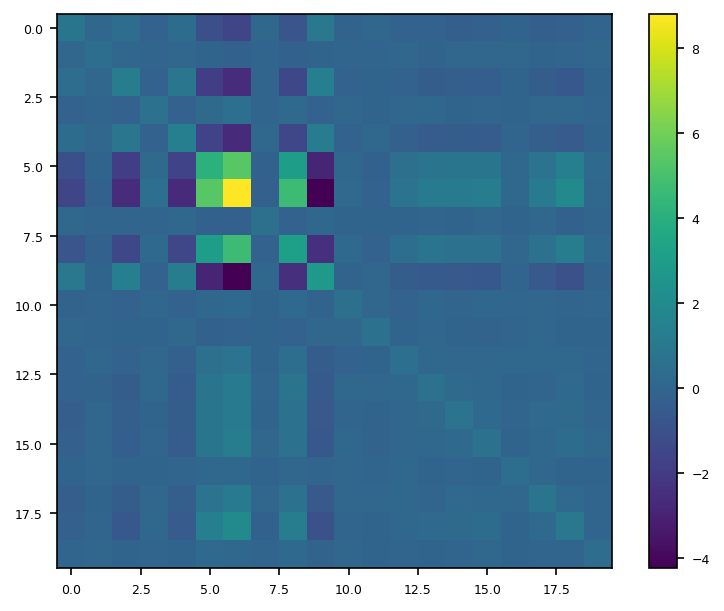

In [421]:
plt.imshow(A)
plt.colorbar()

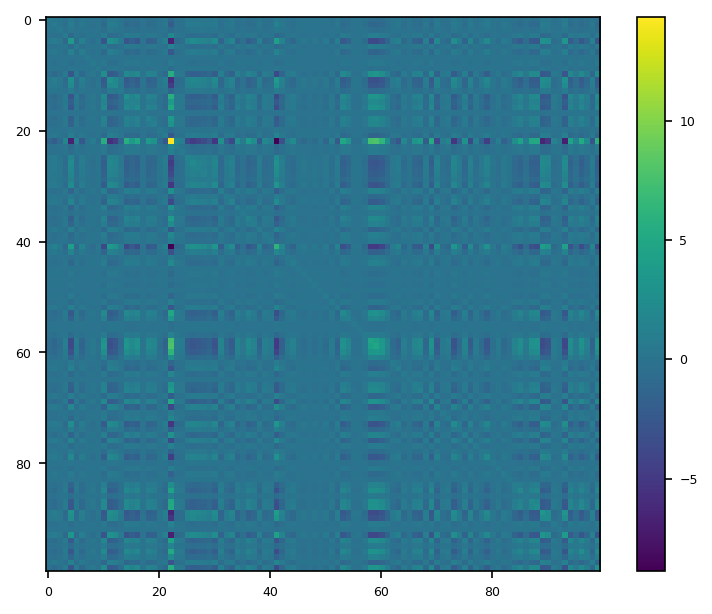

In [422]:
plt.imshow(B)
plt.colorbar()

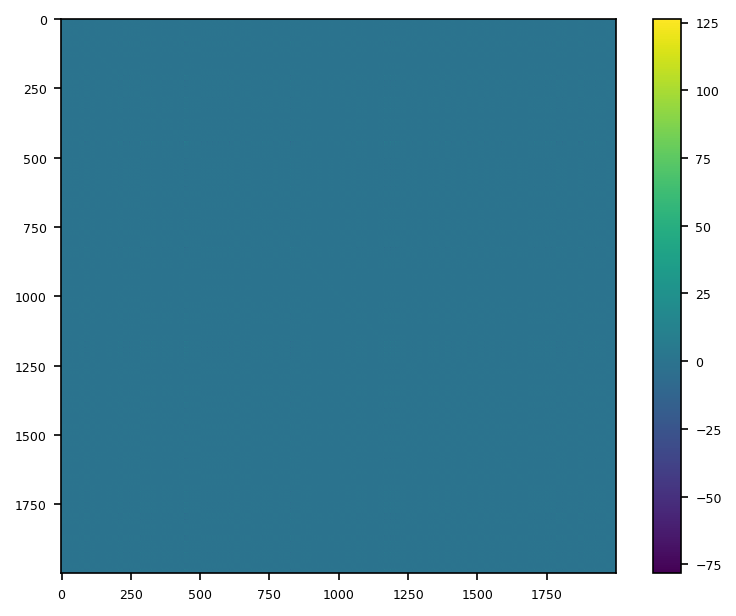

In [423]:
plt.imshow(np.kron(B, A))
plt.colorbar()

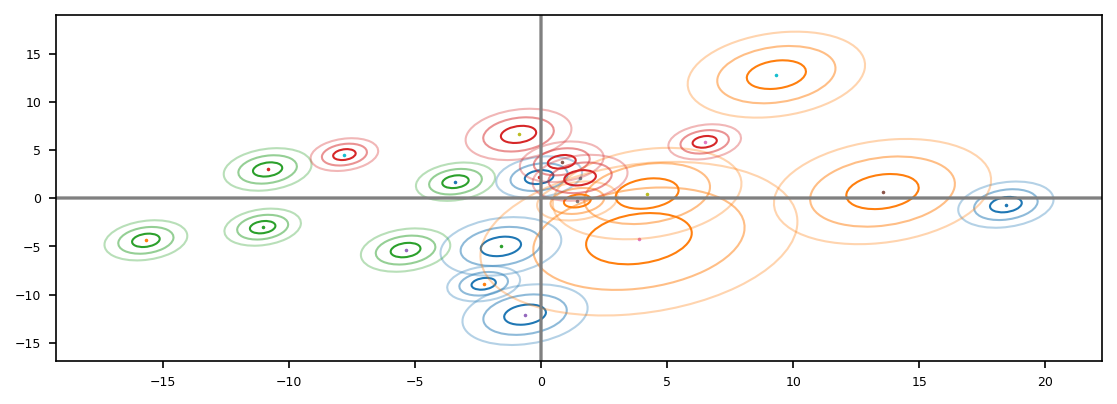

In [424]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
fig, ax = plt.subplots(1, figsize=(9, 3))
for i in range(n):
    ax.scatter(X[i, 3], X[i, 4], s=0.5)

    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)

    confidence_ellipse(X[i, 3], X[i, 4], B*A[i, i], ax, 1, edgecolor=plt.cm.tab10(y[i]), alpha=1)
    confidence_ellipse(X[i, 3], X[i, 4], B*A[i, i], ax, 2, edgecolor=plt.cm.tab10(y[i]), alpha=1/2)
    confidence_ellipse(X[i, 3], X[i, 4], B*A[i, i], ax, 3, edgecolor=plt.cm.tab10(y[i]), alpha=1/3)

    #ax.scatter(mu[0], mu[1], c='red', s=3)
    #ax.set_title(title)

plt.show()

In [425]:
print(X.shape, A.shape, B.shape)

(20, 100) (20, 20) (100, 100)


In [426]:
n_iter=100
V = pca(X_flat, X_unflattener, p_keep)
f = lambda X: pca(X, X_unflattener, p_keep)
_, f_vjp = vjp(f, X_flat)
_, f_jvp = jax.linearize(f, X_flat)
cvp_fun = lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, A, B, n, p, p_keep, s)
#C = np.array([cvp_fun(i) for i in range(min(n, p_keep)*p)])
#C = map(cvp_fun, np.arange(min(n, p_keep)*p))
#C = map(cvp_fun, np.arange(1))
batch_size = 1000
b = batch(np.arange(min(n, p_keep)*p), batch_size)
C = np.vstack([vmap(cvp_fun)(i) for i in b])
key = jax.random.PRNGKey(42)
V_drawn = jax.random.multivariate_normal(key, V, C+1e-5*np.eye(V.shape[0]), shape=(n_iter,))
T_s = np.array([X @ np.transpose(np.reshape(i, (min(n, p_keep), p), 'C')) for i in V_drawn])
pca_mean_T = X@np.transpose(np.reshape(V, (min(n, p_keep), p), 'C'))
#/np.linalg.norm(np.transpose(np.reshape(i, (min(n, p_keep), p), 'C')))

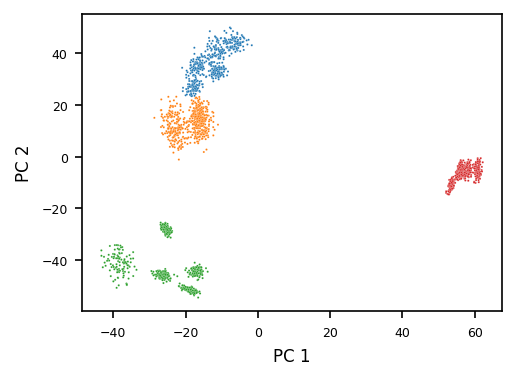

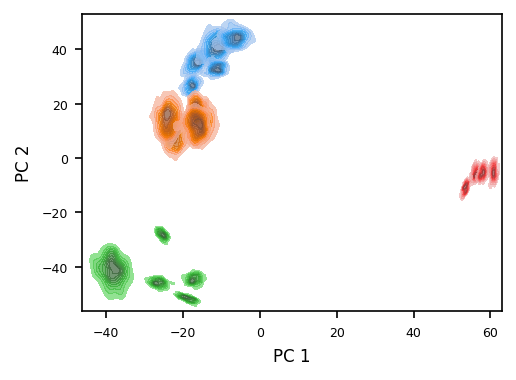

In [427]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8.3*cm, 6*cm), tight_layout = {'pad': 0.1})
fig2, ax2 = plt.subplots(1, 1, figsize=(8.3*cm, 6*cm), tight_layout = {'pad': 0.1})
pcx, pcy = (0, 1)
#sns.scatterplot(x=pca_mean_T[:, 0], y=pca_mean_T[:, 1], s=4, c=[plt.cm.tab10(j) for j in y], ax=ax1)
for j in range(n):
    sns.scatterplot(x=1*T_s[:, j, pcx], y=T_s[:, j, pcy], s=1, c=[plt.cm.tab10(y[j]) for i in range(n_iter)], ax=ax1)#, label=list(d.columns.values)[j], c=['C'+str(labels[j]) for i in range(n_iter)])#, marker=m[labels2[j]], alpha=.5)
    #ax2.scatter(x=T_mcs[:, j, pcx], y=T_mcs[:, j, pcy], s=5)
    sns.kdeplot(x=1*T_s[:, j, pcx], y=T_s[:, j, pcy], shade=True, ax=ax2, color=plt.cm.tab10(y[j]), alpha=0.7)
    #ax2.set_title('kde VIPurPCA')
ax1.set_ylabel('PC 2')
ax1.set_xlabel('PC 1')
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
#ax1.set_ylim(-10, 10)
fig1.tight_layout()
fig2.tight_layout()
fig1.savefig('../results/simulation/simulationoverlayview.pdf')
fig2.savefig('../results/simulation/simulationkde.pdf')

In [428]:
n_samples = 10
S = equipotential_standard_normal(V.shape[0], n_samples+1)
L, lower = jax.scipy.linalg.cho_factor(C+1e-3*np.eye(V.shape[0]), lower=True)
#M_flat, M_unflattener = flatten_util.ravel_pytree(M)
eigv_samples = np.transpose(np.dot(L, S))+V
samples_reshaped = vmap(lambda s: np.transpose(np.reshape(s, (min(n, p_keep), p), 'C')))(eigv_samples)
samples = np.array([X @ i for i in samples_reshaped])

/home/zabel/vipurpca/src/utils.py:87: RuntimeWarning: invalid value encountered in true_divide
  M = np.dot(mu, np.expand_dims(np.cos(theta), axis=0)) + E * np.sin(theta) / theta


In [429]:
samples=samples[:, :, 0:2]

In [430]:
from sklearn.svm import LinearSVC
from sklearn.inspection import DecisionBoundaryDisplay
svms = []
for i in range(n_samples):
    svm = LinearSVC(max_iter=10000, C=0.5)
    svm.fit(samples[i], y)
    svms.append(svm)


/home/zabel/anaconda3/envs/jax_update/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zabel/anaconda3/envs/jax_update/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zabel/anaconda3/envs/jax_update/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zabel/anaconda3/envs/jax_update/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zabel/anaconda3/envs/jax_update/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zabel/anaconda3/env

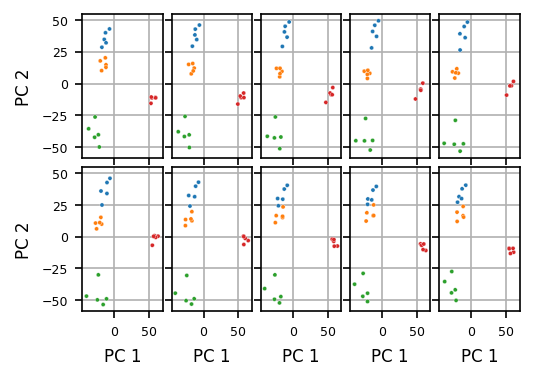

In [431]:
fig, axes = plt.subplots(2, 5, figsize=(8.6*cm, 6*cm), sharex=True, sharey=True, tight_layout = {'pad': 0.1})
ax_list = axes.ravel()
for ax in ax_list:
    ax.set_axisbelow(True)
    ax.grid(True)
for j, sample in enumerate(samples):
    #DecisionBoundaryDisplay.from_estimator(
    #        svms[j], samples[j], response_method="predict",
    #    cmap=plt.cm.coolwarm, alpha=0.8, ax=ax_list[j], eps=1
    #    )
    #w = svms[j].coef_[0]
    #a = -w[0] / w[1]
    #xx = np.linspace(-20, 20)
    #yy = a * xx - (svms[j].intercept_[0]) / w[1]
    #ax_list[j].plot(xx, yy, c='olive', linewidth=1)
    sns.scatterplot(x=sample[:, 0], y=sample[:, 1], s=4, c=[plt.cm.tab10(j) for j in y], ax=ax_list[j]) 
    ax_list[j].set_xlabel('PC 1')
    ax_list[j].set_ylabel('PC 2')
    #ax_list[j].set_xlim(-13, 15)
    #ax_list[j].set_ylim(-3.5, 4.5)
for ax in ax_list:
    ax.label_outer()
plt.tight_layout()
#plt.savefig('../results/vis_evaluation/smallmultiples.pdf')

-58.802525 70.60602


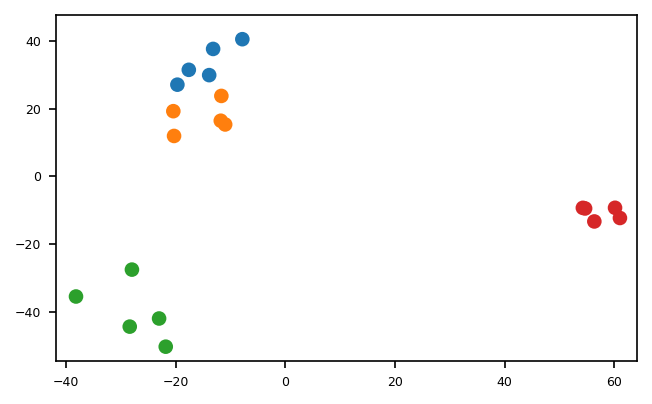

In [432]:
n_samples = len(T_s)
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
fig, ax = plt.subplots(figsize=(5, 3))
sample_0 = samples[0]
labels=y
#sample_0 = sample_0.reshape((len(labels), 2))
minimum = np.min(samples)+0.1*np.min(samples)
maximum = np.max(samples)+0.1*np.max(samples)
print(minimum, maximum)
scat = ax.scatter(sample_0[:, 0], sample_0[:, 1], c=[plt.cm.tab10(j) for j in y])#, cmap='tab10')
#ax.set_xlim((minimum, maximum))
#ax.set_ylim((minimum, maximum))
#scat, = ax.plot([], [], 'o')
def init():
    #scat.set_data([], [])
    #plt.scatter(mean[:, 0], mean[:, 1], c='black')
    return scat,

def animate(i):
    sample_i = samples[i]
    #sample_i = sample_i.reshape((len(labels), 2))
    #scat.set_data(sample_i[:, 0], sample_i[:, 1])
    scat.set_offsets(sample_i)
    return scat, 

anim = FuncAnimation(
    fig, animate, interval=1000, frames=n_samples, blit=True, init_func=init)

anim.save("animation.gif", dpi=150, writer=PillowWriter(fps=5))

In [220]:
from scipy.stats import multivariate_normal
def np_bivariate_normal_pdf(domain, mean, covariance, step):
    X = np.arange(-domain+mean[0], domain+mean[0], step)
    Y = np.arange(-domain+mean[1], domain+mean[1], step)
    X, Y = np.meshgrid(X, Y)
    rv = multivariate_normal(mean, covariance)
    data = np.dstack((X, Y))
    Z = rv.pdf(data)
    return X, Y, Z

for i in range(n):
    #sns.scatterplot(x=[T[i, 0]], y=[T[i, 1]], c=[plt.cm.tab10(y[i])])
    plt.contour(*np_bivariate_normal_pdf(5, T[i, 0:2], B[0:2, 0:2], .25), levels=[0.25, 0.75], linewidths=0.2, colors=[plt.cm.tab10(y[i])])

NameError: name 'T' is not defined

In [ ]:
def pca(X_flat, n, p, p_keep):
    X = np.reshape(X_flat, (n, p), 'F')
    #X = X - np.mean(X, axis=0)
    _, _, V = np.linalg.svd(X, full_matrices=False)
    return flatten_util.ravel_pytree(V[0:p_keep, :])[0]
f = lambda X: pca(X, n, p, p_keep)
J = jacrev(f)(np.ravel(X_unflattener(X_flat), 'F'))

In [11]:
C_jacrev = J @ (np.kron(B, A)) @ J.T

In [12]:
print(C)
print(C_jacrev)

[[ 3.1603586e-03  8.1267666e-05 -1.1915071e-05 -2.1012574e-04
   1.8479257e-04 -3.0677620e-04 -2.7943706e-05  3.8326898e-06
  -5.6826175e-05  1.6543971e-05]
 [ 8.1267659e-05  1.2811608e-05 -7.3732332e-07 -1.7008990e-05
  -3.0833475e-05 -2.9210723e-05 -4.9544691e-05  1.0885720e-06
   3.4654899e-05 -1.1463521e-05]
 [-1.1915082e-05 -7.3732400e-07  1.0450652e-05  5.8430327e-05
   1.7292559e-04  1.0276030e-06  9.7505990e-06 -3.9905670e-05
  -1.7227326e-04  5.8311944e-05]
 [-2.1012570e-04 -1.7008990e-05  5.8430342e-05  1.2540412e-03
   3.7030736e-03 -1.6295300e-04  2.0845669e-04 -1.3218570e-04
  -3.7033444e-03  1.2388092e-03]
 [ 1.8479253e-04 -3.0833460e-05  1.7292557e-04  3.7030734e-03
   1.1142528e-02 -5.6445197e-04  6.2101329e-04 -3.9914818e-04
  -1.1110321e-02  3.7159577e-03]
 [-3.0677591e-04 -2.9210716e-05  1.0276002e-06 -1.6295293e-04
  -5.6445191e-04  9.8340642e-03  4.0093705e-04 -6.2346247e-05
  -1.7501677e-04  1.4091239e-04]
 [-2.7943719e-05 -4.9544684e-05  9.7506008e-06  2.0845675e

In [397]:
T_mean = X@np.transpose(np.reshape(V, (min(n, p_keep), p), 'C'))

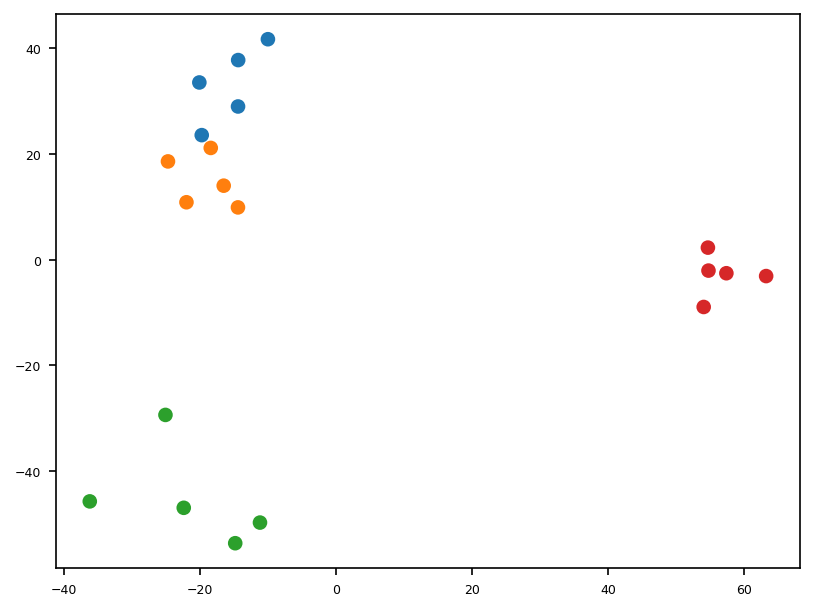

In [398]:
plt.scatter(T_mean[:, 0], T_mean[:, 1], c=[plt.cm.tab10(j) for j in y])